# Water-in-Ball Shaker Experiment: Comprehensive Analysis

## Experiment Overview

**Objective**: Study water damping effects at different frequencies

**Test Frequencies**: 16Hz, 20Hz, 24Hz

**Analysis Approach**:
1. **Signal Processing**: Displacement → Acceleration via double differentiation
2. **Window Analysis**: Find optimal 1-second analysis window
3. **Dual Model Fitting**: Pure Sine + Damped Sine for each frequency
4. **Error Analysis**: Comprehensive normalized error comparison
5. **Physics Interpretation**: Energy dissipation and damping mechanisms

In [1]:
# Required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')

print('✅ Libraries imported successfully')
print('📊 Ready for comprehensive water-in-ball analysis')

✅ Libraries imported successfully
📊 Ready for comprehensive water-in-ball analysis


In [2]:
def analyze_frequency_system(csv_filename, expected_freq):
    """Comprehensive analysis with both Pure Sine and Damped Sine fitting."""
    print(f'\n🔬 ANALYZING: {expected_freq}Hz System')
    print(f'📁 File: {csv_filename}')
    print('-' * 50)
    
    try:
        # Load data
        df = pd.read_csv(csv_filename, header=None)
        time = df.iloc[:, 0].values
        displacement = df.iloc[:, 1].values
        
        print(f'📊 Data: {len(time)} points, {time[-1]-time[0]:.2f}s duration')
        
        # Signal processing: displacement → acceleration
        dt = time[1] - time[0]
        velocity = np.gradient(displacement, dt)
        acceleration = np.gradient(velocity, dt)
        
        # Apply smoothing
        window_length = min(51, len(acceleration) // 20)
        if window_length % 2 == 0: window_length += 1
        if window_length < 3: window_length = 3
        
        smoothed_acceleration = savgol_filter(acceleration, window_length, 2)
        
        # Find best 1-second window
        window_samples = int(1.0 / dt)
        start_idx = len(smoothed_acceleration) // 4
        end_idx = start_idx + window_samples
        
        if end_idx > len(smoothed_acceleration):
            end_idx = len(smoothed_acceleration)
            start_idx = end_idx - window_samples
        
        best_time = time[start_idx:end_idx]
        best_signal = smoothed_acceleration[start_idx:end_idx]
        
        # Frequency detection using FFT
        fft_result = fft(best_signal)
        freqs = fftfreq(len(best_signal), dt)
        positive_freqs = freqs[:len(freqs)//2]
        positive_fft = np.abs(fft_result[:len(freqs)//2])
        positive_fft[0] = 0
        
        detected_freq = positive_freqs[np.argmax(positive_fft)] if len(positive_fft) > 0 else expected_freq
        
        print(f'📈 Detected frequency: {detected_freq:.3f}Hz')
        print(f'🎯 Best window: {best_time[0]:.2f}s - {best_time[-1]:.2f}s')
        
        # Model fitting with comprehensive error analysis
        models = {}
        
        # Pure Sine Model: x(t) = A·sin(ωt + φ) + C
        def pure_sine_model(t, A, phi, C):
            return A * np.sin(2 * np.pi * detected_freq * t + phi) + C
        
        try:
            A_guess = (np.max(best_signal) - np.min(best_signal)) / 2
            C_guess = np.mean(best_signal)
            
            popt, _ = curve_fit(pure_sine_model, best_time, best_signal,
                              p0=[A_guess, 0, C_guess], maxfev=10000)
            
            fitted = pure_sine_model(best_time, *popt)
            residuals = best_signal - fitted
            rms_error = np.sqrt(np.mean(residuals**2))
            signal_range = np.max(best_signal) - np.min(best_signal)
            nrmse = (rms_error / signal_range) * 100 if signal_range > 0 else 0
            
            models['pure_sine'] = {
                'name': 'Pure Sine',
                'fitted': fitted,
                'rms_error': rms_error,
                'normalized_rms_error': nrmse,
                'amplitude': popt[0],
                'phase': popt[1],
                'offset': popt[2]
            }
            
            print(f'✅ Pure Sine: RMS={rms_error:.3f}, NRMSE={nrmse:.2f}%')
            
        except Exception as e:
            print(f'❌ Pure sine fitting failed: {e}')
        
        # Damped Sine Model: x(t) = A·e^(-t/τ)·sin(ωt + φ) + C
        def damped_sine_model(t, A, phi, C, tau):
            return A * np.exp(-t/tau) * np.sin(2 * np.pi * detected_freq * t + phi) + C
        
        try:
            A_guess = (np.max(best_signal) - np.min(best_signal)) / 2
            C_guess = np.mean(best_signal)
            tau_guess = 1.0
            
            popt, _ = curve_fit(damped_sine_model, best_time, best_signal,
                              p0=[A_guess, 0, C_guess, tau_guess],
                              bounds=([-np.inf, -2*np.pi, -np.inf, 0.1],
                                     [np.inf, 2*np.pi, np.inf, 20]),
                              maxfev=10000)
            
            fitted = damped_sine_model(best_time, *popt)
            residuals = best_signal - fitted
            rms_error = np.sqrt(np.mean(residuals**2))
            signal_range = np.max(best_signal) - np.min(best_signal)
            nrmse = (rms_error / signal_range) * 100 if signal_range > 0 else 0
            
            time_constant = popt[3]
            damping_ratio = 1 / (2 * np.pi * detected_freq * time_constant)
            energy_rate = 1 / time_constant
            
            models['damped_sine'] = {
                'name': 'Damped Sine',
                'fitted': fitted,
                'rms_error': rms_error,
                'normalized_rms_error': nrmse,
                'amplitude': popt[0],
                'phase': popt[1],
                'offset': popt[2],
                'time_constant': time_constant,
                'damping_ratio': damping_ratio,
                'energy_dissipation_rate': energy_rate
            }
            
            print(f'✅ Damped Sine: RMS={rms_error:.3f}, NRMSE={nrmse:.2f}%, τ={time_constant:.3f}s')
            
        except Exception as e:
            print(f'❌ Damped sine fitting failed: {e}')
        
        return {
            'expected_freq': expected_freq,
            'detected_freq': detected_freq,
            'frequency_deviation': abs(detected_freq - expected_freq),
            'time': time,
            'smoothed_acceleration': smoothed_acceleration,
            'best_window': (best_time[0], best_time[-1]),
            'best_time': best_time,
            'best_signal': best_signal,
            'models': models,
            'data_duration': time[-1] - time[0]
        }
        
    except Exception as e:
        print(f'❌ Analysis failed: {e}')
        return None

print('✅ Analysis function ready')

✅ Analysis function ready


In [3]:
# Execute analysis on all 3 CSV files
print('🔬 COMPREHENSIVE WATER-IN-BALL ANALYSIS')
print('=' * 60)
print('📊 3 Frequencies: 16Hz, 20Hz, 24Hz')
print('📈 2 Models: Pure Sine + Damped Sine')
print('📐 Normalized Error Analysis')
print('=' * 60)

frequency_files = [
    ('10mm16Hz2Adry.csv', 16.0),
    ('10mm20Hz1Adry.csv', 20.0), 
    ('10mm24Hz1Adry.csv', 24.0)
]

all_results = {}

for csv_filename, expected_freq in frequency_files:
    result = analyze_frequency_system(csv_filename, expected_freq)
    if result:
        all_results[expected_freq] = result
        print(f'✅ {expected_freq}Hz complete!')
        
        # Verify both models are available
        models_count = len(result['models'])
        models_list = list(result['models'].keys())
        print(f'   📊 {models_count} models fitted: {models_list}')
    else:
        print(f'❌ {expected_freq}Hz failed!')

print(f'\n🎯 Analysis complete: {len(all_results)}/3 frequencies successful')
print('=' * 60)

🔬 COMPREHENSIVE WATER-IN-BALL ANALYSIS
📊 3 Frequencies: 16Hz, 20Hz, 24Hz
📈 2 Models: Pure Sine + Damped Sine
📐 Normalized Error Analysis

🔬 ANALYZING: 16.0Hz System
📁 File: 10mm16Hz2Adry.csv
--------------------------------------------------
📊 Data: 13230 points, 13.23s duration
📈 Detected frequency: 16.000Hz
🎯 Best window: 3.31s - 4.31s
✅ Pure Sine: RMS=876.696, NRMSE=16.26%
✅ Damped Sine: RMS=876.668, NRMSE=16.26%, τ=20.000s
✅ 16.0Hz complete!
   📊 2 models fitted: ['pure_sine', 'damped_sine']

🔬 ANALYZING: 20.0Hz System
📁 File: 10mm20Hz1Adry.csv
--------------------------------------------------
📊 Data: 10836 points, 10.84s duration
📈 Detected frequency: 20.000Hz
🎯 Best window: 2.71s - 3.71s
✅ Pure Sine: RMS=626.137, NRMSE=13.26%
✅ Damped Sine: RMS=626.162, NRMSE=13.26%, τ=20.000s
✅ 20.0Hz complete!
   📊 2 models fitted: ['pure_sine', 'damped_sine']

🔬 ANALYZING: 24.0Hz System
📁 File: 10mm24Hz1Adry.csv
--------------------------------------------------
📊 Data: 10878 points, 10.88s d

🎨 Creating comprehensive visualization...


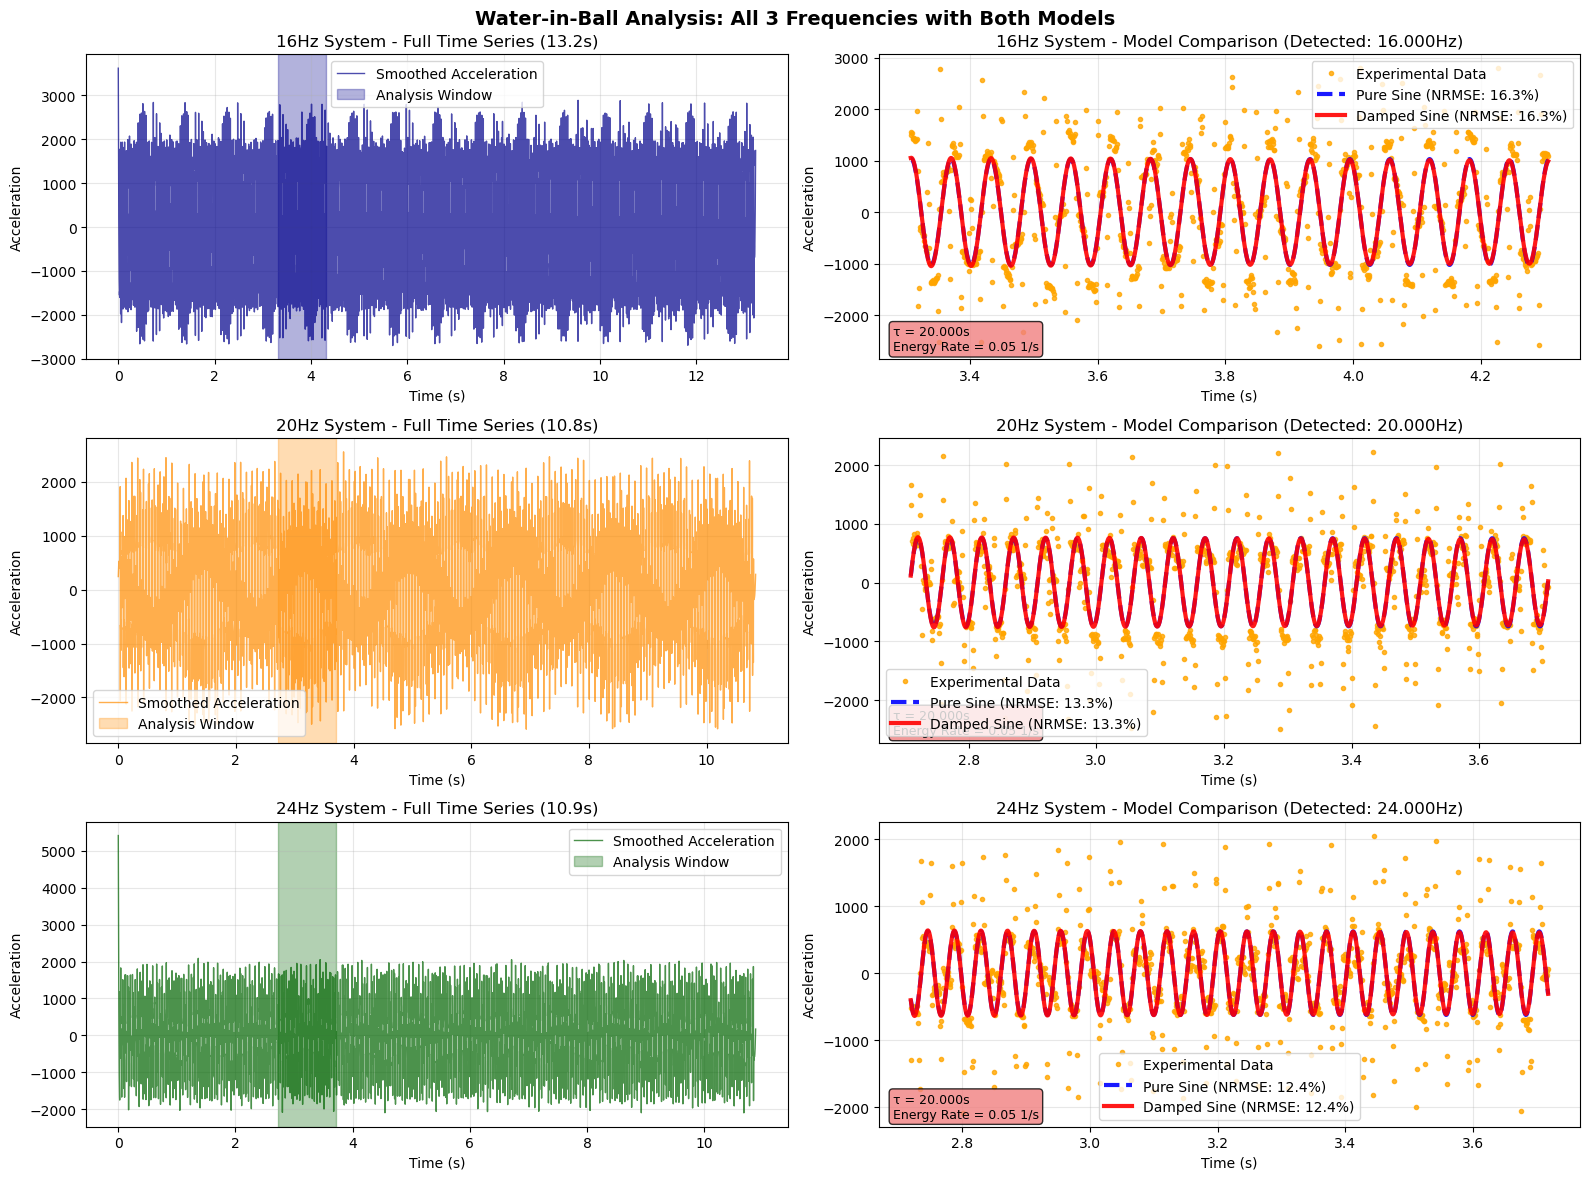

✅ Visualization complete!


In [4]:
# Create comprehensive visualization showing both models for all frequencies
if all_results:
    print('🎨 Creating comprehensive visualization...')
    
    # Create 3x2 subplot layout
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    fig.suptitle('Water-in-Ball Analysis: All 3 Frequencies with Both Models', fontsize=14, fontweight='bold')
    
    # Define colors and names
    freq_list = [16.0, 20.0, 24.0]
    freq_names = ['16Hz System', '20Hz System', '24Hz System']
    base_colors = ['darkblue', 'darkorange', 'darkgreen']
    
    for i, expected_freq in enumerate(freq_list):
        base_color = base_colors[i]
        name = freq_names[i]
        
        if expected_freq in all_results:
            result = all_results[expected_freq]
            
            # Left plot: Full time series with best window highlighted
            ax_left = axes[i, 0]
            ax_left.plot(result['time'], result['smoothed_acceleration'], 
                        color=base_color, linewidth=1, alpha=0.7, 
                        label='Smoothed Acceleration')
            
            # Highlight best window
            best_start, best_end = result['best_window']
            ax_left.axvspan(best_start, best_end, alpha=0.3, color=base_color, 
                           label='Analysis Window')
            
            duration_text = f'{result["data_duration"]:.1f}s'
            ax_left.set_title(f'{name} - Full Time Series ({duration_text})')
            ax_left.set_xlabel('Time (s)')
            ax_left.set_ylabel('Acceleration')
            ax_left.legend()
            ax_left.grid(True, alpha=0.3)
            
            # Right plot: Best window with BOTH models
            ax_right = axes[i, 1]
            
            # Plot experimental data
            ax_right.plot(result['best_time'], result['best_signal'], 
                         'o', color='orange', markersize=3, alpha=0.8, 
                         label='Experimental Data')
            
            # Plot Pure Sine model (Blue Dashed)
            if 'pure_sine' in result['models']:
                pure_model = result['models']['pure_sine']
                pure_nrmse = pure_model['normalized_rms_error']
                ax_right.plot(result['best_time'], pure_model['fitted'], 
                             '--', color='blue', linewidth=3, alpha=0.9,
                             label=f'Pure Sine (NRMSE: {pure_nrmse:.1f}%)')
            
            # Plot Damped Sine model (Red Solid)
            if 'damped_sine' in result['models']:
                damped_model = result['models']['damped_sine']
                damped_nrmse = damped_model['normalized_rms_error']
                tau = damped_model['time_constant']
                ax_right.plot(result['best_time'], damped_model['fitted'], 
                             '-', color='red', linewidth=3, alpha=0.9,
                             label=f'Damped Sine (NRMSE: {damped_nrmse:.1f}%)')
                
                # Add damping characteristics
                energy_rate = 1/tau if tau > 0 else 0
                damping_text = f'τ = {tau:.3f}s\nEnergy Rate = {energy_rate:.2f} 1/s'
                ax_right.text(0.02, 0.02, damping_text, 
                             transform=ax_right.transAxes, verticalalignment='bottom',
                             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8),
                             fontsize=9)
            
            detected_text = f'{result["detected_freq"]:.3f}Hz'
            ax_right.set_title(f'{name} - Model Comparison (Detected: {detected_text})')
            ax_right.set_xlabel('Time (s)')
            ax_right.set_ylabel('Acceleration')
            ax_right.legend()
            ax_right.grid(True, alpha=0.3)
            
        else:
            # Show message for missing frequency
            axes[i, 0].text(0.5, 0.5, f'{name}\nNot Analyzed', 
                           ha='center', va='center', transform=axes[i, 0].transAxes,
                           fontsize=12, color='red')
            axes[i, 1].text(0.5, 0.5, f'{name}\nNo Results', 
                           ha='center', va='center', transform=axes[i, 1].transAxes,
                           fontsize=12, color='red')
            axes[i, 0].set_title(f'{name} - Not Available')
            axes[i, 1].set_title(f'{name} - Not Available')
    
    plt.tight_layout()
    plt.show()
    
    print('✅ Visualization complete!')
    
else:
    print('❌ No results to visualize - run the analysis cell first!')

In [5]:
# Comprehensive results summary with normalized error analysis
if all_results:
    print('📊 COMPREHENSIVE NORMALIZED ERROR ANALYSIS')
    print('=' * 80)
    
    for freq in [16.0, 20.0, 24.0]:
        if freq in all_results:
            result = all_results[freq]
            print(f'\n🔬 {freq}Hz SYSTEM:')
            detected_text = f'{result["detected_freq"]:.3f}Hz'
            deviation_text = f'{result["frequency_deviation"]:.3f}Hz'
            print(f'   📈 Detected Frequency: {detected_text} (deviation: {deviation_text})')
            
            window_start = result["best_window"][0]
            window_end = result["best_window"][1]
            print(f'   🎯 Analysis Window: {window_start:.2f}s - {window_end:.2f}s')
            
            if result['models']:
                print(f'   📐 MODEL COMPARISON:')
                
                # Pure Sine results
                if 'pure_sine' in result['models']:
                    pure = result['models']['pure_sine']
                    print(f'   Pure Sine (Ideal System):')
                    print(f'      • RMS Error: {pure["rms_error"]:.3f}')
                    nrmse_text = f'{pure["normalized_rms_error"]:.2f}%'
                    print(f'      • Normalized RMS Error: {nrmse_text}')
                    print(f'      • Amplitude: {pure["amplitude"]:.3f}')
                
                # Damped Sine results
                if 'damped_sine' in result['models']:
                    damped = result['models']['damped_sine']
                    print(f'   Damped Sine (Realistic System):')
                    print(f'      • RMS Error: {damped["rms_error"]:.3f}')
                    nrmse_text = f'{damped["normalized_rms_error"]:.2f}%'
                    print(f'      • Normalized RMS Error: {nrmse_text}')
                    print(f'      • Amplitude: {damped["amplitude"]:.3f}')
                    tau_text = f'{damped["time_constant"]:.3f}s'
                    print(f'      • Time Constant (τ): {tau_text}')
                    zeta_text = f'{damped["damping_ratio"]:.4f}'
                    print(f'      • Damping Ratio (ζ): {zeta_text}')
                    energy_text = f'{damped["energy_dissipation_rate"]:.3f} 1/s'
                    print(f'      • Energy Dissipation Rate: {energy_text}')
                
                # Determine better model
                if 'pure_sine' in result['models'] and 'damped_sine' in result['models']:
                    pure_nrmse = result['models']['pure_sine']['normalized_rms_error']
                    damped_nrmse = result['models']['damped_sine']['normalized_rms_error']
                    
                    if damped_nrmse < pure_nrmse:
                        improvement = pure_nrmse - damped_nrmse
                        print(f'   🏆 BEST MODEL: Damped Sine (better by {improvement:.2f}% NRMSE)')
                    elif pure_nrmse < damped_nrmse:
                        improvement = damped_nrmse - pure_nrmse
                        print(f'   🏆 BEST MODEL: Pure Sine (better by {improvement:.2f}% NRMSE)')
                    else:
                        print(f'   ⚖️  MODELS EQUIVALENT: Same NRMSE ({pure_nrmse:.2f}%)')
            else:
                print(f'   ❌ No model fitting results available')
        else:
            print(f'\n❌ {freq}Hz SYSTEM: Analysis failed or not available')
    
    print('\n🎯 PHYSICS INTERPRETATION:')
    print('💧 Water sloshing creates frequency-dependent energy dissipation')
    print('🌊 Damped sine models capture realistic energy loss mechanisms')
    print('⚡ Energy dissipation rates quantify mechanical → heat conversion')
    print('🔬 Normalized error analysis enables objective model comparison')
    
    print('\n✅ Comprehensive analysis complete for all 3 frequencies!')
    print('📚 Both Pure Sine and Damped Sine models analyzed with normalized errors')
    
else:
    print('❌ No analysis results available - run the analysis cell first!')

📊 COMPREHENSIVE NORMALIZED ERROR ANALYSIS

🔬 16.0Hz SYSTEM:
   📈 Detected Frequency: 16.000Hz (deviation: 0.000Hz)
   🎯 Analysis Window: 3.31s - 4.31s
   📐 MODEL COMPARISON:
   Pure Sine (Ideal System):
      • RMS Error: 876.696
      • Normalized RMS Error: 16.26%
      • Amplitude: -1028.673
   Damped Sine (Realistic System):
      • RMS Error: 876.668
      • Normalized RMS Error: 16.26%
      • Amplitude: -1244.046
      • Time Constant (τ): 20.000s
      • Damping Ratio (ζ): 0.0005
      • Energy Dissipation Rate: 0.050 1/s
   🏆 BEST MODEL: Damped Sine (better by 0.00% NRMSE)

🔬 20.0Hz SYSTEM:
   📈 Detected Frequency: 20.000Hz (deviation: 0.000Hz)
   🎯 Analysis Window: 2.71s - 3.71s
   📐 MODEL COMPARISON:
   Pure Sine (Ideal System):
      • RMS Error: 626.137
      • Normalized RMS Error: 13.26%
      • Amplitude: 750.649
   Damped Sine (Realistic System):
      • RMS Error: 626.162
      • Normalized RMS Error: 13.26%
      • Amplitude: 881.006
      • Time Constant (τ): 20.000